<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/sample_emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [3]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, \
Conv1D, MaxPool1D, AveragePooling1D, GlobalAveragePooling1D, GlobalAvgPool1D, \
GlobalMaxPool1D, GlobalMaxPooling1D 
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.optimizers import Adam, RMSprop
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate
from sklearn.utils import class_weight
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/emotion/data/go_preprocessed.csv'
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
seed = 123456
num_words = 10000
max_len = 250

In [5]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
318,get blood orgies out of our ideology thanks,anger
86774,shocked we did not take him back and plunk him...,surprise
77098,goalpost shifting much,surprise
32737,when i do begin to peak all of name will know,joy
6216,whats all this meow,anger


In [6]:
train, test = train_test_split(data, test_size=0.35, \
                             random_state=seed, stratify=data['target'])

In [7]:
val, test = train_test_split(test, test_size=0.5, \
                             random_state=seed, stratify=test['target'])

In [8]:
train.shape, val.shape, test.shape

((57870, 2), (15580, 2), (15581, 2))

In [9]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [10]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])
sequence_test = get_sequences(tokenizer, max_len, test['text'])

In [11]:
print(val['target'].unique(), \
      train['target'].unique(), \
      test['target'].unique())

['joy' 'anger' 'disgust' 'surprise' 'sadness' 'fear'] ['fear' 'joy' 'sadness' 'anger' 'surprise' 'disgust'] ['sadness' 'surprise' 'anger' 'joy' 'disgust' 'fear']


In [12]:
strategy = {"anger":60000, "disgust":60000, "fear":60000, "joy":40000, "sadness":60000, "surprise":60000}
oversample = SMOTE(sampling_strategy=strategy)
sequence_train, train_target = oversample.fit_resample(sequence_train,\
                                                       train['target'])

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (60000) in class anger will be larger than the number of samples in the majority class (class #joy -> 22893)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (60000) in class disgust will be larger than the number of samples in the majority class (class #joy -> 22893)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (60000) in class fear will be larger than the number of samples in the majority class (class #joy -> 22893)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (40000) in class joy will be larger than the number of samples in the majority clas

Class=fear, n=60000 (17.647%)
Class=joy, n=40000 (11.765%)
Class=sadness, n=60000 (17.647%)
Class=anger, n=60000 (17.647%)
Class=surprise, n=60000 (17.647%)
Class=disgust, n=60000 (17.647%)


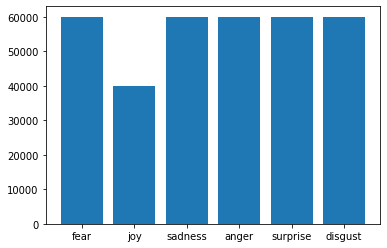

In [13]:
counter = Counter(train_target)
for k,v in counter.items():
	per = v / len(train_target) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [14]:
train_target = OH_fit_transform(pd.Series(train_target))
val_target = OH_transform(val['target'])
test_target = OH_transform(test['target'])

In [99]:
def build_mlp():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(80, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(80, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(6, activation='softmax'))
    return model

In [28]:
def build_emb():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Embedding(num_words,32))
    model.add(Flatten())
    model.add(Dense(6, activation='softmax'))
    return model

In [51]:
mlp_model = build_mlp()
mlp_model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 40)                10040     
_________________________________________________________________
dense_14 (Dense)             (None, 60)                2460      
_________________________________________________________________
dense_15 (Dense)             (None, 80)                4880      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               8100      
_________________________________________________________________
dense_17 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_18 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_19 (Dense)             (None, 40)               

In [56]:
mlp_cb = get_callbacks('mlp_3H.h5')

In [57]:
history_mlp = mlp_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=mlp_cb
)

Epoch 1/100
905/905 [==============================] - 4s 4ms/step - loss: 1.5289 - accuracy: 0.3956 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5291 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.52914, saving model to mlp_3H.h5
Epoch 2/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5290 - accuracy: 0.3956 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5291 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00002: val_loss improved from 1.52914 to 1.52906, saving model to mlp_3H.h5
Epoch 3/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5290 - accuracy: 0.3956 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5289 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00003: val_loss improved from 1.52906 to 1.52895, saving model to mlp_3H.h5
Epoch 4/

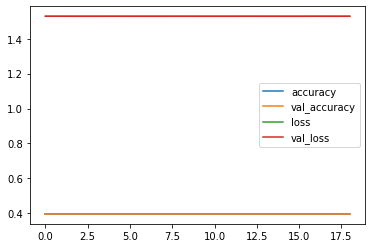

In [80]:
pd.DataFrame(history_mlp.history)[metr].plot()

 85/244 [=========>....................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 0s 1ms/step
Accuracy:	39.6%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3099
           1       0.00      0.00      0.00       708
           2       0.00      0.00      0.00       540
           3       0.40      1.00      0.57      6164
           4       0.00      0.00      0.00      2004
           5       0.00      0.00      0.00      3066

    accuracy                           0.40     15581
   macro avg       0.07      0.17      0.09     15581
weighted avg       0.16      0.40      0.22     15581



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


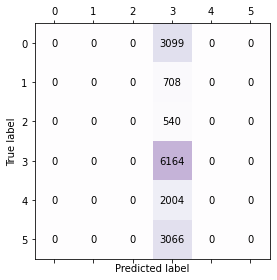

In [90]:
model_evaluate(mlp_model, sequence_test, test_target, 64)

## With oversampling

In [126]:
mlp_model2 = build_mlp()
mlp_model2.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
mlp_model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 40)                10040     
_________________________________________________________________
dense_40 (Dense)             (None, 60)                2460      
_________________________________________________________________
dense_41 (Dense)             (None, 80)                4880      
_________________________________________________________________
dense_42 (Dense)             (None, 100)               8100      
_________________________________________________________________
dense_43 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_44 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_45 (Dense)             (None, 40)              

In [127]:
mlp2_cb = get_callbacks('mlp2_3H.h5')

In [128]:
history_mlp2 = mlp_model2.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=mlp2_cb
)

Epoch 1/100
5625/5625 [==============================] - 15s 3ms/step - loss: 1.8212 - accuracy: 0.1655 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.7927 - val_accuracy: 0.1988 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.79273, saving model to mlp2_3H.h5
Epoch 2/100
5625/5625 [==============================] - 14s 3ms/step - loss: 1.7919 - accuracy: 0.1672 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.7956 - val_accuracy: 0.1968 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.79273
Epoch 3/100
5625/5625 [==============================] - 14s 3ms/step - loss: 1.7920 - accuracy: 0.1657 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.7868 - val_accuracy: 0.3956 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00

Epoch 00003: val_loss improved from 1.79273 to 1.78684, saving model to mlp2_3H.h5
Epoch 4/100
5625

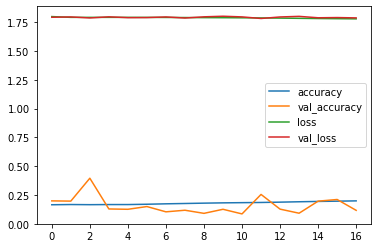

In [129]:
pd.DataFrame(history_mlp2.history)[metr].plot()

100/244 [===========>..................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 0s 1ms/step
Accuracy:	25.5%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3099
           1       0.00      0.00      0.00       708
           2       0.03      0.38      0.06       540
           3       0.40      0.61      0.48      6164
           4       0.00      0.00      0.00      2004
           5       0.00      0.00      0.00      3066

    accuracy                           0.26     15581
   macro avg       0.07      0.17      0.09     15581
weighted avg       0.16      0.26      0.19     15581



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


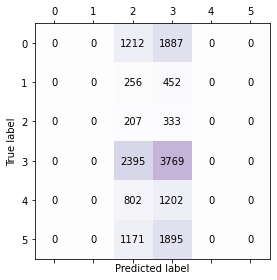

In [130]:
model_evaluate(mlp_model2, sequence_test, test_target, 64)

In [54]:
emb_cb = get_callbacks('emb_3H.h5')

In [59]:
emb_model = build_emb()
emb_model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
emb_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 32)           320000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 48006     
Total params: 368,006
Trainable params: 368,006
Non-trainable params: 0
_________________________________________________________________


In [60]:
history_emb = emb_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=emb_cb
)

Epoch 1/100
905/905 [==============================] - 11s 11ms/step - loss: 1.5705 - accuracy: 0.3917 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.5269 - val_accuracy: 0.3956 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.52694, saving model to emb.h5
Epoch 2/100
905/905 [==============================] - 9s 10ms/step - loss: 1.5260 - accuracy: 0.3942 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.5234 - val_accuracy: 0.3956 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00

Epoch 00002: val_loss improved from 1.52694 to 1.52342, saving model to emb.h5
Epoch 3/100
905/905 [==============================] - 9s 10ms/step - loss: 1.5220 - accuracy: 0.3954 - precision_7: 0.4282 - recall_7: 8.1752e-05 - val_loss: 1.5180 - val_accuracy: 0.3956 - val_precision_7: 1.0000 - val_recall_7: 1.9255e-04

Epoch 00003: val_loss improved from 1.52342 to 1.51803, saving model to emb.h5
Epoch 4/100
905/905 [

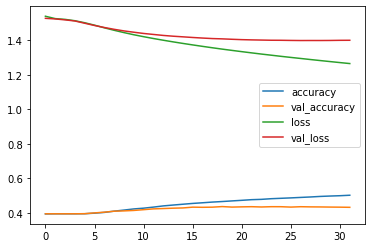

In [61]:
pd.DataFrame(history_emb.history)[metr].plot()

 49/244 [=====>........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 1s 2ms/step
Accuracy:	43.1%


              precision    recall  f1-score   support

           0       0.31      0.36      0.34      3099
           1       0.00      0.00      0.00       708
           2       0.00      0.00      0.00       540
           3       0.50      0.78      0.61      6164
           4       0.34      0.10      0.15      2004
           5       0.33      0.19      0.24      3066

    accuracy                           0.43     15581
   macro avg       0.25      0.24      0.22     15581
weighted avg       0.37      0.43      0.37     15581



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


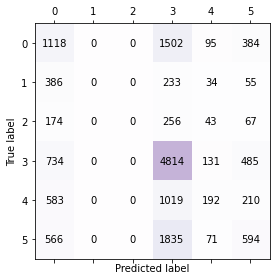

In [70]:
model_evaluate(emb_model, sequence_test, test_target, 64)

## With oversampling

In [133]:
emb_cb2 = get_callbacks('emb2_3H.h5')

In [132]:
emb_model2 = build_emb()
emb_model2.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
emb_model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 32)           320000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 48006     
Total params: 368,006
Trainable params: 368,006
Non-trainable params: 0
_________________________________________________________________


In [134]:
history_emb2 = emb_model2.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=emb_cb2
)

Epoch 1/100
5625/5625 [==============================] - 47s 8ms/step - loss: 1.7906 - accuracy: 0.1773 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 1.7762 - val_accuracy: 0.2879 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.77618, saving model to emb2_3H.h5
Epoch 2/100
5625/5625 [==============================] - 45s 8ms/step - loss: 1.7850 - accuracy: 0.1946 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 1.7520 - val_accuracy: 0.2901 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00

Epoch 00002: val_loss improved from 1.77618 to 1.75202, saving model to emb2_3H.h5
Epoch 3/100
5625/5625 [==============================] - 45s 8ms/step - loss: 1.7758 - accuracy: 0.2148 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_loss: 1.7125 - val_accuracy: 0.3284 - val_precision_11: 1.0000 - val_recall_11: 6.4185e-05

Epoch 00003: val_loss improved from 1.75202 to 1.71247, saving model to

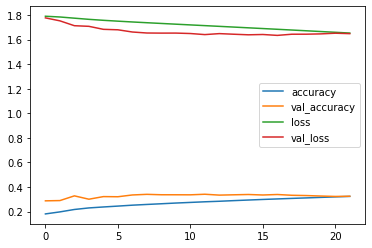

In [135]:
pd.DataFrame(history_emb2.history)[metr].plot()

 64/244 [======>.......................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 0s 2ms/step
Accuracy:	33.7%


              precision    recall  f1-score   support

           0       0.29      0.21      0.24      3099
           1       0.08      0.18      0.11       708
           2       0.06      0.15      0.08       540
           3       0.49      0.61      0.55      6164
           4       0.22      0.10      0.14      2004
           5       0.24      0.13      0.17      3066

    accuracy                           0.34     15581
   macro avg       0.23      0.23      0.21     15581
weighted avg       0.33      0.34      0.32     15581



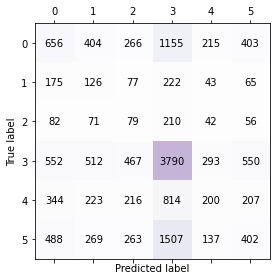

In [136]:
model_evaluate(emb_model2, sequence_test, test_target, 64)

In [15]:
def build_lstm():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Embedding(num_words,32))
    model.add(LSTM(20))
    model.add(Dense(6, activation='softmax'))
    return model

In [16]:
ls_model = build_lstm()
ls_model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
ls_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 20)                4240      
_________________________________________________________________
dense (Dense)                (None, 6)                 126       
Total params: 324,366
Trainable params: 324,366
Non-trainable params: 0
_________________________________________________________________


In [17]:
cb_ls = get_callbacks('lstm.h5')

In [18]:
history_ls = ls_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=cb_ls
)

Epoch 1/100
5313/5313 [==============================] - 87s 15ms/step - loss: 1.7826 - accuracy: 0.1809 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.8436 - val_accuracy: 0.1951 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.84363, saving model to lstm.h5
Epoch 2/100
5313/5313 [==============================] - 80s 15ms/step - loss: 1.7671 - accuracy: 0.2075 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.7947 - val_accuracy: 0.2463 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00002: val_loss improved from 1.84363 to 1.79469, saving model to lstm.h5
Epoch 3/100
5313/5313 [==============================] - 80s 15ms/step - loss: 1.7546 - accuracy: 0.2188 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.7762 - val_accuracy: 0.2540 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00003: val_loss improved from 1.79469 to 1.77615, saving model to lstm.h5
Ep

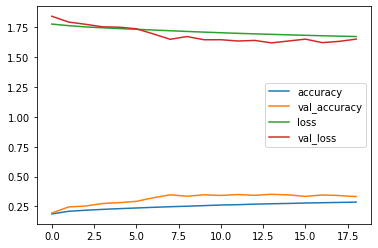

In [19]:
pd.DataFrame(history_ls.history)[metr].plot()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


244/244 [==============================] - 2s 6ms/step
Accuracy:	35.1%


              precision    recall  f1-score   support

           0       0.29      0.27      0.28      3099
           1       0.10      0.16      0.12       708
           2       0.10      0.17      0.12       540
           3       0.54      0.56      0.55      6164
           4       0.24      0.06      0.09      2004
           5       0.24      0.28      0.26      3066

    accuracy                           0.35     15581
   macro avg       0.25      0.25      0.24     15581
weighted avg       0.35      0.35      0.34     15581



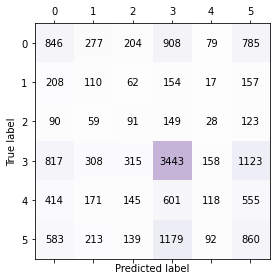

In [20]:
model_evaluate(ls_model, sequence_test, test_target, 64)